#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m + cum_i)
    return np.array(fin_123[::-1])

In [16]:
lll = [100 for i in range(node_N)]

In [17]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [18]:
cum_d_inv

[5000,
 4900,
 4800,
 4700,
 4600,
 4500,
 4400,
 4300,
 4200,
 4100,
 4000,
 3900,
 3800,
 3700,
 3600,
 3500,
 3400,
 3300,
 3200,
 3100,
 3000,
 2900,
 2800,
 2700,
 2600,
 2500,
 2400,
 2300,
 2200,
 2100,
 2000,
 1900,
 1800,
 1700,
 1600,
 1500,
 1400,
 1300,
 1200,
 1100,
 1000,
 900,
 800,
 700,
 600,
 500,
 400,
 300,
 200,
 100,
 10]

In [19]:
Ws = np.array(mi)*9.81

In [20]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [21]:
# Irho+=vessel_inertia

In [22]:
Irho[-1][0][0]

60761404731.24999

In [23]:
Irho[-49][0][0]

441458471931.25

In [24]:
Irho

array([[[4.65002472e+11, 4.04250480e+11, 4.04250480e+11],
        [4.04250480e+11, 4.65002472e+11, 4.04250480e+11],
        [4.04250480e+11, 4.04250480e+11, 4.65002477e+11]],

       [[4.41458472e+11, 3.80706480e+11, 3.80706480e+11],
        [3.80706480e+11, 4.41458472e+11, 3.80706480e+11],
        [3.80706480e+11, 3.80706480e+11, 4.41458477e+11]],

       [[4.18846814e+11, 3.58094822e+11, 3.58094822e+11],
        [3.58094822e+11, 4.18846814e+11, 3.58094822e+11],
        [3.58094822e+11, 3.58094822e+11, 4.18846819e+11]],

       [[3.97148664e+11, 3.36396672e+11, 3.36396672e+11],
        [3.36396672e+11, 3.97148664e+11, 3.36396672e+11],
        [3.36396672e+11, 3.36396672e+11, 3.97148668e+11]],

       [[3.76345185e+11, 3.15593194e+11, 3.15593194e+11],
        [3.15593194e+11, 3.76345185e+11, 3.15593194e+11],
        [3.15593194e+11, 3.15593194e+11, 3.76345190e+11]],

       [[3.56417544e+11, 2.95665552e+11, 2.95665552e+11],
        [2.95665552e+11, 3.56417544e+11, 2.95665552e+11],
    

In [25]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [26]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [27]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [28]:
E = 210e9

In [29]:
E*Ar/1e10

1.6991625880187402

In [30]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [31]:
DT=np.diag(diag_DT) # (35) in [2]

In [32]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [33]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [34]:
CT=np.diag(diag_CT)

In [35]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [36]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [37]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [38]:
rng = np.random.default_rng()

In [39]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [40]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [41]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.78095479,  0.61197378,  0.12489076],
       [-0.48890874,  0.47452737,  0.73197816],
       [ 0.38868736, -0.63270203,  0.66978375]])

In [42]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.012222


In [43]:
Ret.shape

(50, 3, 3)

In [44]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [45]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [46]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000329


In [47]:
C1(dx,dy,dz,Ret)

array([[ 2.77683279e-01,  1.70344804e+00, -1.69978281e-01,
        -7.11109489e-02, -2.52591312e-01, -3.34502982e+00,
        -1.30948838e-04, -1.10136181e+00, -1.80244036e+00,
        -2.52247871e+00, -7.25728817e-01,  3.53387579e-02,
        -6.00256255e-05,  5.14808596e-01, -4.25122562e+00,
        -1.32039940e-01, -1.02777812e-01, -3.66366209e-02,
         2.67442882e+00,  7.70874893e-03,  1.74501818e+00,
        -7.86814845e-01,  3.92376752e+00,  1.20578215e-01,
        -6.10911674e-01,  1.64684395e+00, -1.75572734e+00,
         1.31794685e+00,  6.34786130e-02, -2.40939903e+00,
         3.16182445e-01, -4.43752873e-01,  4.60485258e-02,
        -5.23040578e-01,  1.04032171e+00, -5.50254937e-02,
         1.59439290e+00,  3.11729547e+00,  6.23867027e-01,
         3.00849722e+00,  2.79780058e-01,  1.02595589e-01,
        -7.19742344e-02, -3.16444516e+00, -2.43243074e+00,
         2.08045833e+00, -3.93302367e-01,  1.04619830e-01,
        -4.88965308e-01, -1.47272905e-01],
       [-8.27

In [48]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [49]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.59363376e+03, -4.75074395e+02,  8.38836891e+02],
       [ 9.77614612e+03, -1.87122966e+04,  1.57329773e+03],
       [-9.75511126e+02, -1.95626637e+03, -5.22576875e+03],
       [-4.08108149e+02,  2.96026419e+02, -1.67584440e+01],
       [-1.44963011e+03,  1.60177209e+04,  4.58574230e+03],
       [-1.91972397e+04, -5.30290988e+03, -8.33479154e+02],
       [-7.51519823e-01,  1.82865088e+04, -8.27980709e+02],
       [-6.32075283e+03,  7.17244191e+01,  2.05677211e+03],
       [-1.03442664e+04, -2.37148585e+02,  7.73454923e+03],
       [-1.44765909e+04,  1.44026542e+04, -1.59168891e+04],
       [-4.16498231e+03, -2.89878755e+03,  1.29254865e+03],
       [ 2.02810331e+02,  1.99755256e+04,  1.28973080e+04],
       [-3.44489102e-01,  6.44962588e+03, -2.82096488e+03],
       [ 2.95450401e+03, -1.25571222e+04,  2.13623809e+03],
       [-2.43979281e+04,  3.84156267e+03,  4.13645474e+03],
       [-7.57781698e+02,  7.06882775e+02,  4.27574352e+02],
       [-5.89845350e+02, -1.30148682e+03

In [50]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000504


In [51]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [52]:
I=np.identity(3)

In [53]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000326


In [54]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [55]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [56]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [57]:
DR=np.diag(diag_DR) 

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [61]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [62]:
def Re_b(Ret):
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000152


In [64]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [65]:
phi(x,y,z,Ret,None,None)

array([[ 0.78579819,  0.41557023, -1.00362752],
       [-1.0705209 , -0.76906402, -0.6595376 ],
       [-0.93140373, -0.1966571 , -0.79200516],
       [ 0.2380622 , -0.88124678,  1.19859585],
       [-0.62789833, -1.18235842, -0.60777852],
       [ 1.18449191, -0.02277292,  0.27754956],
       [ 0.78165608, -0.74246081,  0.281983  ],
       [-0.59924947, -0.68304656, -2.572726  ],
       [ 1.65911097, -0.10440741, -1.38644833],
       [-0.95805979, -1.79552574,  0.08030077],
       [-0.36315084,  1.53526172,  0.87473298],
       [-1.05278017, -0.18347819, -0.15956301],
       [ 0.17995744, -0.38973712, -2.08832414],
       [-0.91230915,  0.26267888,  0.11948604],
       [ 0.15215245,  0.69754318, -0.76678162],
       [-1.83929844, -0.82173092,  1.1161608 ],
       [ 0.76944577, -0.29665156,  1.27050523],
       [ 1.92173309, -2.01100822, -1.64444984],
       [-0.52025788, -0.27680751,  0.47628531],
       [-0.36987441, -2.46382037,  1.21298686],
       [-0.74617441, -1.89649052,  0.224

In [66]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000461


In [67]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [68]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [69]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.007210


In [70]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [71]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001611


In [72]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.08376261, -0.22365181, -0.63145486],
       [-0.90725925, -0.4014726 , -0.38551038],
       [ 0.2550866 ,  0.47716041,  1.80360737],
       [ 1.07565055,  0.81155709,  0.84384523],
       [-0.76683923,  0.53875554,  0.85728291],
       [ 0.99009224,  0.28618861, -0.19154418],
       [ 0.77916643,  0.08145876, -0.0882187 ],
       [-0.58401571,  0.82406416,  0.7895148 ],
       [ 1.40993484,  1.89950207,  1.08482649],
       [-0.83285672, -0.46976971, -0.60533007],
       [ 0.72096017,  1.31172915,  1.24396328],
       [-0.37151968, -0.82070591, -0.9904733 ],
       [-0.3187632 , -0.92702515,  0.38816963],
       [-0.51846458, -0.63820793, -0.05548437],
       [-1.00119784,  2.92230669, -1.11070141],
       [ 1.02771863, -0.41162553,  0.87739854],
       [ 0.93945726,  1.17497787, -1.32491226],
       [ 0.10609111,  1.08083323,  1.46706918],
       [-0.04766064, -0.73114967,  0.37329409],
       [ 0.42034347,  1.32361747,  1.81235291],
       [-0.34779298, -0.63560939, -0.371

In [73]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [74]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [75]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-1.27534906e-02,  9.45848093e-04, -5.36937109e-03,
         1.86761310e-02,  5.11056948e-03,  2.70221608e-03,
         9.18301493e-03, -1.70458530e-02, -1.15459441e-02,
         1.67920075e-02, -5.86586417e-03,  2.05716268e-04,
        -1.53104200e-02, -1.27528721e-03, -1.31450171e-02,
         1.74014374e-02,  1.40915647e-02,  3.19485251e-03,
         6.76466691e-03,  3.29690126e-02,  1.89939653e-02,
        -1.80030946e-02, -2.20693333e-02,  7.94673641e-03,
        -4.79435442e-03, -1.37580345e-02,  1.25111485e-02,
         1.18485664e-02,  8.97792581e-03, -2.22117238e-02,
         1.52951971e-02, -1.03534798e-02, -9.57850234e-03,
        -1.16275651e-03,  4.68250118e-03,  7.76859396e-03,
        -5.51134867e-03,  5.82693602e-03, -5.58176120e-03,
        -8.51252741e-03, -2.94382194e-02,  2.80218129e-03,
        -9.25910099e-03, -2.32255887e-02, -2.58201870e-02,
        -2.18847517e-02,  3.65248337e-03, -7.46533775e-04,
        -1.65664291e-02,  4.49330576e-03],
       [ 1.07

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002632


In [77]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [78]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [79]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [81]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-7.26760551e-07,  1.81348500e-07,  4.77302224e-07,
         7.25606738e-08,  2.17482660e-06,  1.11817608e-06,
         8.36329950e-07,  3.40531202e-06,  1.05780895e-06,
        -1.02944475e-06,  6.94881498e-07, -4.58251688e-07,
        -5.86407497e-07, -8.09817937e-09, -2.19876838e-07,
         1.00060896e-06,  9.55678665e-07,  3.60929663e-06,
         2.49773699e-07, -3.47366851e-06, -2.62512066e-07,
        -1.09156628e-06, -1.19942980e-06,  1.33007246e-07,
        -1.73968361e-06, -1.57346919e-06,  3.13259430e-07,
         8.33848203e-07,  6.02209510e-07, -1.28362912e-06,
        -1.62149224e-06,  1.88003083e-06, -1.76233988e-06,
         8.81259748e-08,  1.34013598e-06,  1.02816663e-06,
        -1.92471504e-06,  1.92726280e-06,  2.96437712e-07,
        -7.31004557e-07, -3.27306150e-06,  8.35134974e-07,
        -2.14877823e-06, -3.04918301e-06, -2.68068485e-07,
        -2.41477560e-06, -8.73716851e-07,  3.09762593e-07,
         2.15157445e-06,  1.26019284e-06],
       [ 2.06

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.59363376e+03, -9.77614612e+03,  9.75511126e+02,
         4.08108149e+02,  1.44963011e+03,  1.91972397e+04,
         7.51519823e-01,  6.32075283e+03,  1.03442664e+04,
         1.44765909e+04,  4.16498231e+03, -2.02810331e+02,
         3.44489102e-01, -2.95450401e+03,  2.43979281e+04,
         7.57781698e+02,  5.89845350e+02,  2.10258811e+02,
        -1.53486378e+04, -4.42407717e+01, -1.00147186e+04,
         4.51555710e+03, -2.25186349e+04, -6.92002467e+02,
         3.50604283e+03, -9.45129334e+03,  1.00761788e+04,
        -7.56374170e+03, -3.64305914e+02,  1.38276228e+04,
        -1.81458178e+03,  2.54671280e+03, -2.64274052e+02,
         3.00174763e+03, -5.97044161e+03,  3.15793176e+02,
        -9.15027498e+03, -1.78902645e+04, -3.58039404e+03,
        -1.72658677e+04, -1.60566725e+03, -5.88799570e+02,
         4.13062574e+02,  1.81608581e+04,  1.39598026e+04,
        -1.19398210e+04,  2.25717563e+03, -6.00416755e+02,
         2.80618850e+03,  8.45204202e+02],
       [ 4.75

In [84]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.005944


In [85]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-9.43194953e+03,  2.89853042e+07,  6.62902564e+07],
       [-4.87041131e+03,  3.02211748e+07,  1.89758523e+07],
       [ 3.35221438e+01, -1.13851111e+04, -3.27238927e+05],
       [ 1.49111716e+03, -8.23141510e+06, -6.83071801e+06],
       [ 6.18346628e+03, -5.09275558e+07, -1.15322735e+07],
       [ 2.65595358e+02, -1.80456779e+07,  1.53636754e+07],
       [-2.26305694e+02, -6.39823880e+06,  8.68459459e+06],
       [ 7.52951167e+03, -5.57887640e+07, -2.02679237e+07],
       [ 8.68150344e+02,  3.12427183e+06, -1.18940685e+07],
       [ 3.12560346e+02,  8.04088934e+06, -1.11986315e+07],
       [ 2.50210485e+03, -2.43320726e+07, -9.41757309e+05],
       [-8.49196435e+03,  6.51950689e+07,  2.05833774e+07],
       [ 1.02098627e+03,  4.86486188e+07, -5.89645976e+07],
       [-3.12885908e+01,  4.05242171e+07, -4.02102084e+07],
       [-5.09540031e+02,  4.44145044e+05,  4.70296140e+06],
       [-2.19762229e+02,  1.72520379e+06,  4.94641393e+05],
       [ 1.55302435e+01, -1.46741222e+05

In [86]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-8.19036925e+09,  6.62821479e+09, -2.89934122e+09],
       [-8.09704478e+09,  1.89678362e+09, -3.02291905e+09],
       [-1.14878752e+10, -3.38611925e+07,  1.26890323e+03],
       [-7.38638767e+07, -6.83079113e+08,  8.23134197e+08],
       [-1.56127610e+09, -1.15338191e+09,  5.09260102e+09],
       [-1.05518365e+10,  1.53532291e+09,  1.80352321e+09],
       [-1.65504317e+10,  8.66820966e+08,  6.38185470e+08],
       [-2.25887869e+09, -2.02701600e+09,  5.57865278e+09],
       [ 1.80054006e+09, -1.18922859e+09, -3.12248938e+08],
       [-1.07331800e+10, -1.12092573e+09, -8.05151465e+08],
       [ 1.19835540e+08, -9.41638672e+07,  2.43321912e+09],
       [-8.38464334e+08,  2.05825473e+09, -6.51958990e+09],
       [-2.47099104e+09, -5.89670439e+09, -4.86510650e+09],
       [-7.59276769e+09, -4.02177252e+09, -4.05317336e+09],
       [ 8.41524951e+09,  4.71129250e+08, -4.35814368e+07],
       [-1.29787546e+10,  4.81792424e+07, -1.73805211e+08],
       [-9.74142307e+08, -1.10948124e+06

In [87]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000724


In [88]:
Re_b(Ret).shape

(50, 3, 3)

In [89]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [90]:
Irho_e(Ret,Irho)

array([[[ 1.91049332e+11,  7.58537628e+11,  3.73439907e+11],
        [-1.89385734e+10,  1.68394663e+11,  9.55449437e+10],
        [ 2.03798476e+11,  7.58779654e+11,  4.71944287e+11]],

       [[ 4.15181696e+11,  3.04101506e+11,  9.20387785e+11],
        [ 1.65966145e+11,  9.13423201e+10,  4.64248961e+11],
        [ 1.63391843e+11,  4.40236158e+10,  2.49527156e+11]],

       [[ 1.00503792e+11, -1.22693572e+11,  2.31249291e+10],
        [ 2.36816355e+11, -6.08390311e+11,  2.78483023e+11],
        [-3.46288777e+11,  6.96179579e+11, -4.02050265e+11]],

       [[ 6.32532604e+10,  5.58602979e+10,  1.79391168e+11],
        [ 4.09739764e+11,  9.13406974e+10,  5.63517672e+11],
        [ 4.73241102e+11,  1.86890655e+11,  6.00156440e+11]],

       [[-1.52645445e+11,  1.28364475e+11, -2.63071691e+11],
        [ 3.93598454e+11, -5.34490153e+11,  6.84699388e+11],
        [-6.08413269e+10,  1.19888965e+10,  1.60803635e+10]],

       [[ 7.84601918e+10,  6.06890406e+11, -1.62653735e+11],
        [-4.89

In [91]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.000505


In [92]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [93]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [94]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [95]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32))

In [96]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002754


In [97]:
d_me_

array([[ 2.02799150e-10, -2.80493870e-07, -2.78297014e-06],
       [ 2.01255950e-10, -9.77872870e-08, -1.30055677e-06],
       [ 2.54111277e-10, -4.33499579e-09, -5.02825337e-13],
       [ 8.78663756e-12, -1.76173938e-08, -1.19501917e-06],
       [ 6.71714155e-11, -3.94074999e-08, -1.86363116e-06],
       [ 2.40113436e-10, -9.14165241e-08, -1.05019949e-06],
       [ 3.24143643e-10, -2.15969566e-07, -1.47318731e-06],
       [ 8.59261206e-11, -9.74920897e-08, -1.46689114e-06],
       [ 7.38698068e-11, -3.54182304e-08, -4.11597339e-07],
       [ 2.42856965e-10, -9.61110295e-08, -3.14065633e-07],
       [ 1.21317208e-11, -2.55905668e-09, -1.27565611e-06],
       [ 4.43800113e-11, -7.25104913e-08, -1.89515414e-06],
       [ 9.12243648e-11, -3.33077991e-07, -1.16724124e-06],
       [ 1.92810649e-10, -3.22000805e-07, -1.23800154e-06],
       [ 2.06494992e-10, -2.07931167e-08, -3.50244680e-08],
       [ 2.75647220e-10, -1.83734678e-08, -7.29290785e-08],
       [ 4.90471484e-11, -1.17891275e-09

In [98]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [99]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.59363376e+03, -9.77614612e+03,  9.75511126e+02,
         4.08108149e+02,  1.44963011e+03,  1.91972397e+04,
         7.51519823e-01,  6.32075283e+03,  1.03442664e+04,
         1.44765909e+04,  4.16498231e+03, -2.02810331e+02,
         3.44489102e-01, -2.95450401e+03,  2.43979281e+04,
         7.57781698e+02,  5.89845350e+02,  2.10258811e+02,
        -1.53486378e+04, -4.42407717e+01, -1.00147186e+04,
         4.51555710e+03, -2.25186349e+04, -6.92002467e+02,
         3.50604283e+03, -9.45129334e+03,  1.00761788e+04,
        -7.56374170e+03, -3.64305914e+02,  1.38276228e+04,
        -1.81458178e+03,  2.54671280e+03, -2.64274052e+02,
         3.00174763e+03, -5.97044161e+03,  3.15793176e+02,
        -9.15027498e+03, -1.78902645e+04, -3.58039404e+03,
        -1.72658677e+04, -1.60566725e+03, -5.88799570e+02,
         4.13062574e+02,  1.81608581e+04,  1.39598026e+04,
        -1.19398210e+04,  2.25717563e+03, -6.00416755e+02,
         2.80618850e+03,  8.45204202e+02],
       [ 4.75

### Static solution

In [100]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [101]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [102]:
Fx_0=82945396

In [103]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [104]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [105]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [106]:
delta_x=horizontal_length/(node_N-1)

In [107]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [108]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [109]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [110]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [111]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

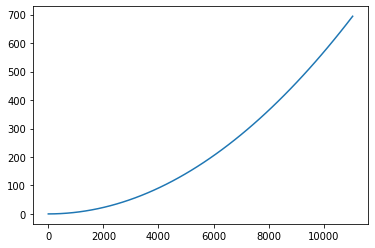

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [114]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [115]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [116]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [117]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [118]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [119]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [120]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [121]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [122]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [123]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

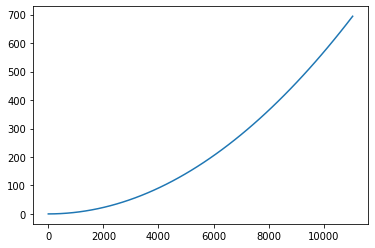

In [124]:
plt.plot(x0_, z0_)
plt.show()

In [125]:
np.cosh(50)/np.cosh(50)

1.0

In [126]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==7:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# # q0[9*node_N-1]=0.13  # here
# q0[7*node_N-1]=-2.7483793019200675e-11 # here
# q0[9*node_N-1]=0  # here
# q0[11*node_N-1]=1.764854928865134e-11  # here

In [127]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [128]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [129]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [130]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [131]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

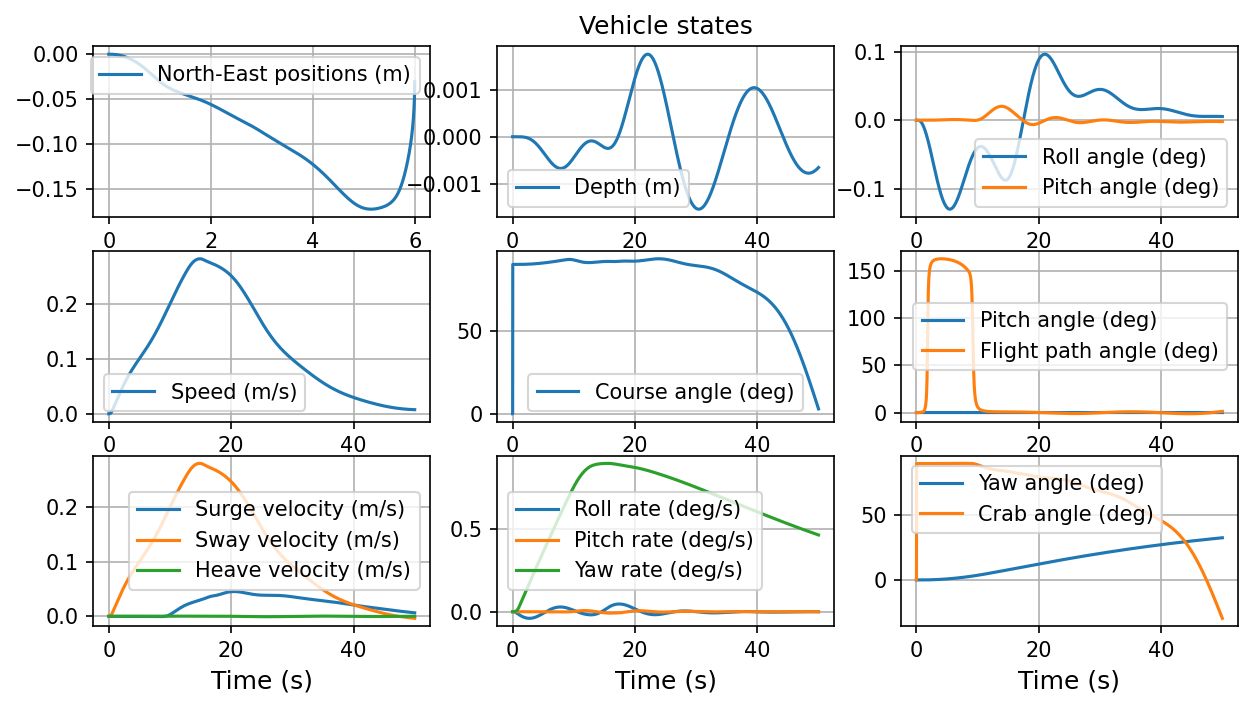

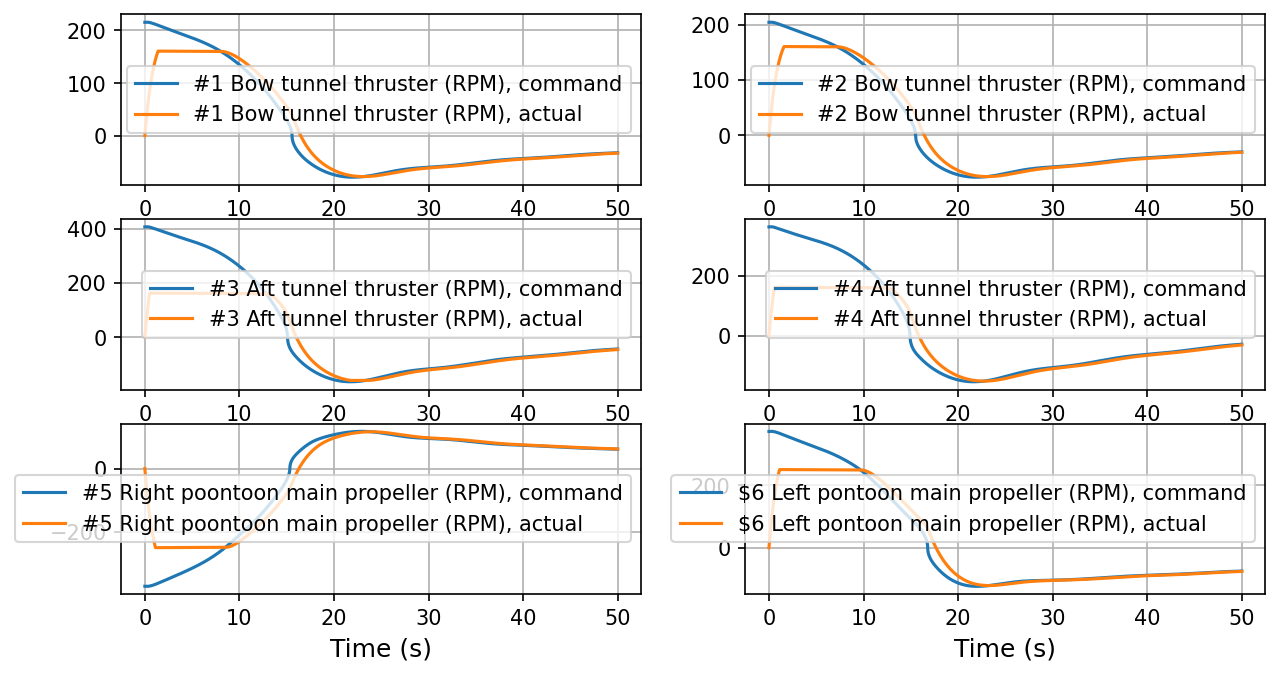

In [132]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [133]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

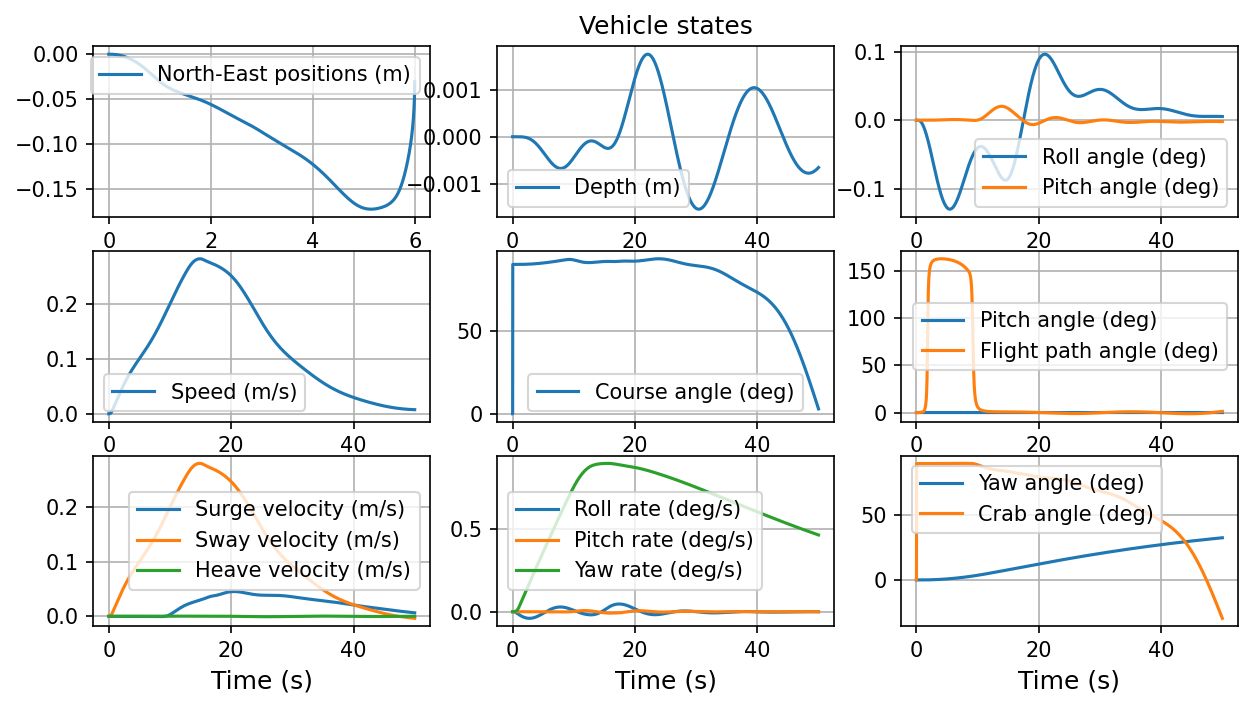

In [134]:
plotVehicleStates(simTime, simData, 3)

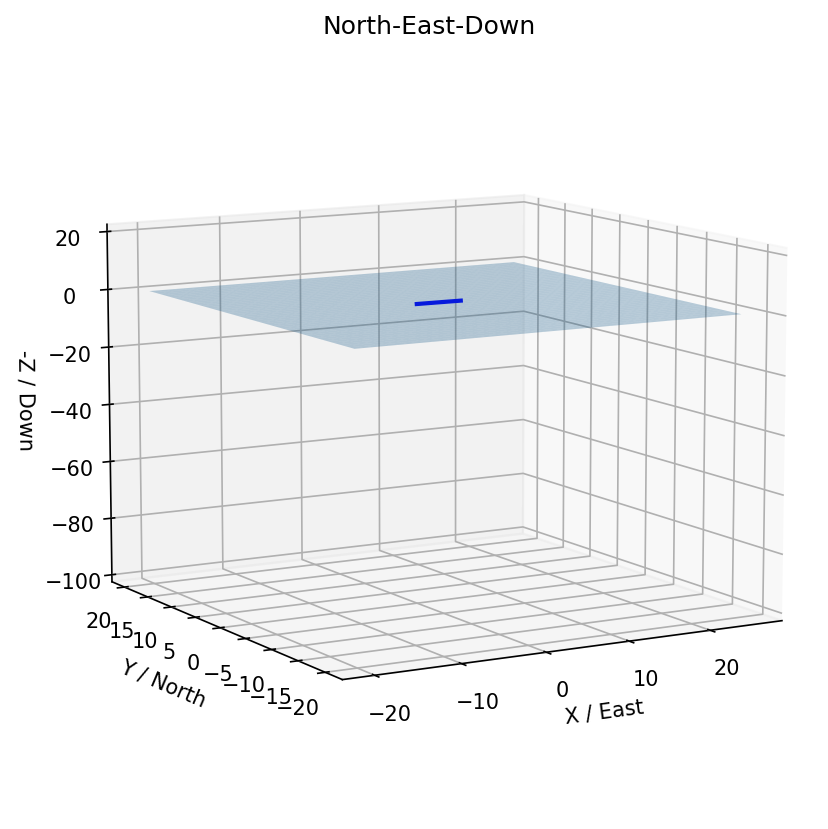

In [135]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [136]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [137]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [138]:
# Ws[0]*Ret[2]

In [139]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [140]:
idx=1/0.01

In [141]:
idx

100.0

In [142]:
ssa(simData[:, 3][int(idx)])

-0.00010522890316932987

In [143]:
ssa(simData[:, 4][int(idx)])

6.952842745988619e-09

In [144]:
ssa(simData[:, 5][int(idx)])

0.00010649100253301569

### Dynamics

In [145]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
#     force_schedule=9.81
    force_schedule=1
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(tau_force[:3])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret)
#     print(Z0)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)
  
    Z= (Z1 + Z2 +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
#                                              M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
#     print(lll) 

#     lll=length_p   
    
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   
#     print(cum_d_inv[0])
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho[12])
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################
#     print(B[49])
#     print()

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [146]:
# import scipy

In [147]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [148]:
# us=ode15s.integrate(10)

In [149]:
tspan = (0., 0.10)

In [150]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:32.502032


In [151]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init) and force_schedule 

# the main problem of the model is that it accelirates too much
# the hack increases the mass, the greater the mass the lesser the  acceleration
# the force_schedule affects the force, the lesser the force the lesser the  acceleration
# bc set conditions on how much force from the vessel should be applied to counteract the movement because of bc

# too fast acceleration leads to solution divergence in short amount of time

### Results

In [152]:
fin=us

In [153]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1580
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.61448030e-09, 5.22583917e-08, 2.23910156e-07,
       8.57944320e-07, 3.11944822e-06, 1.11104856e-05, 3.92860577e-05,
       1.38582347e-04, 4.88371215e-04, 1.31031224e-03, 2.13225326e-03,
       2.93933626e-03, 3.98402463e-03, 5.33704448e-03, 7.17033200e-03,
       9.18889949e-03, 1.12074670e-02, 1.28067085e-02, 1.44059500e-02,
       1.63031348e-02, 1.80589994e-02, 1.98148639e-02, 2.16814041e-02,
       2.34774273e-02, 2.51041342e-02, 2.66637055e-02, 2.83769147e-02,
       3.02578974e-02, 3.18792432e-02, 3.35005890e-02, 3.53315093e-02,
       3.72158450e-02, 3.87044828e-02, 4.01931207e-02, 4.20244830e-02,
       4.37306510e-02, 4.54368190e-02, 4.71887942e-02, 4.86303489e-02,
       5.00719036e-02, 5.18315280e-02, 5.34397147e-02, 5.50479013e-02,
       5.67448295e-02, 5.81018478e-02, 

In [154]:
t=fin.t

In [155]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


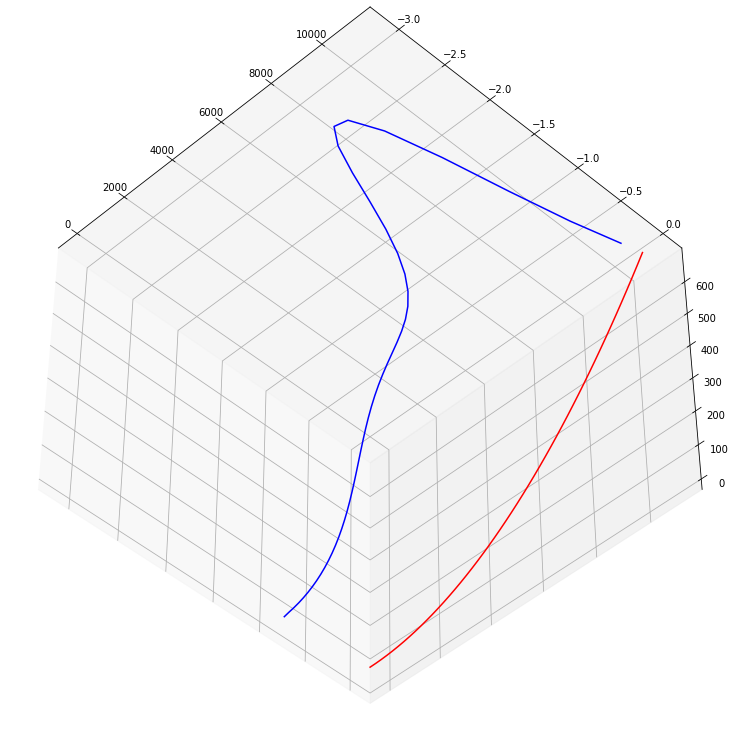

In [156]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)

# ax.view_init(0,-90)
plt.show()

In [157]:
X,Y,Z

(array([-2.55313545e-01,  2.25203517e+02,  4.50674283e+02,  6.76152475e+02,
         9.01635908e+02,  1.12712345e+03,  1.35261451e+03,  1.57810880e+03,
         1.80360621e+03,  2.02910676e+03,  2.25461052e+03,  2.48011759e+03,
         2.70562806e+03,  2.93114199e+03,  3.15665932e+03,  3.38217987e+03,
         3.60770323e+03,  3.83322865e+03,  4.05875493e+03,  4.28428028e+03,
         4.50980206e+03,  4.73531659e+03,  4.96081897e+03,  5.18630286e+03,
         5.41176068e+03,  5.63718391e+03,  5.86256382e+03,  6.08789222e+03,
         6.31316190e+03,  6.53836648e+03,  6.76349985e+03,  6.98855525e+03,
         7.21352443e+03,  7.43839668e+03,  7.66315769e+03,  7.88778815e+03,
         8.11226188e+03,  8.33654378e+03,  8.56058781e+03,  8.78433679e+03,
         9.00772646e+03,  9.23069782e+03,  9.45322007e+03,  9.67531925e+03,
         9.89709685e+03,  1.01187172e+04,  1.03403570e+04,  1.05621381e+04,
         1.07840796e+04,  1.10043912e+04]),
 array([-0.94843823, -0.95884596, -0.9664118

In [158]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [159]:
us=fin.T

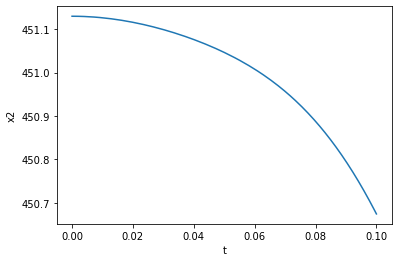

In [160]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

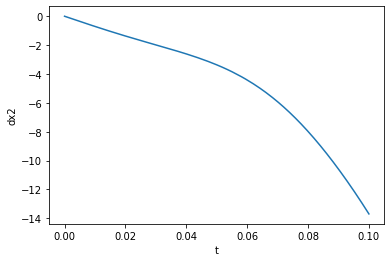

In [161]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

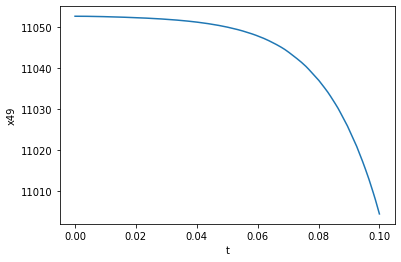

In [162]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

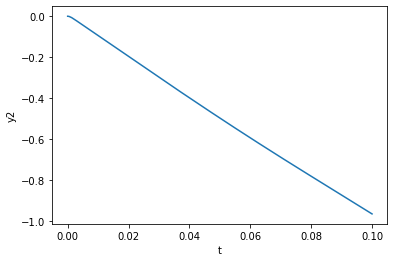

In [163]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

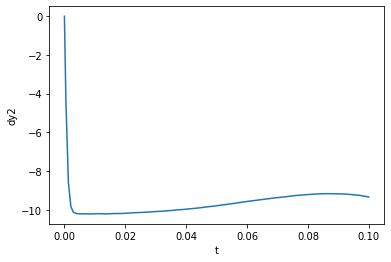

In [164]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

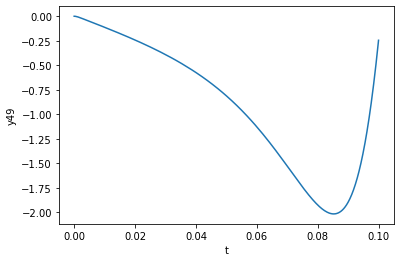

In [165]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

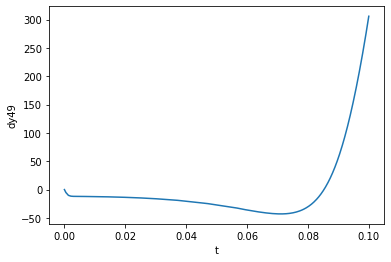

In [166]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

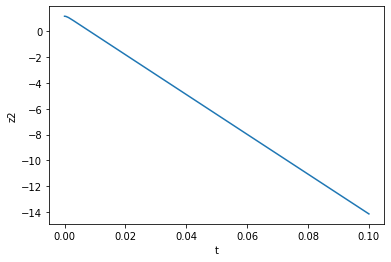

In [167]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

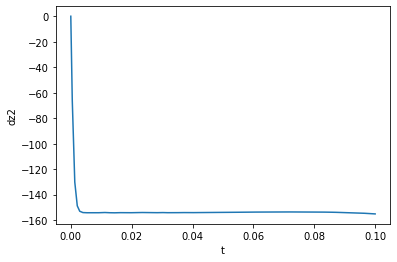

In [168]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

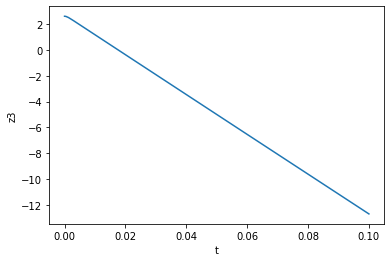

In [169]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

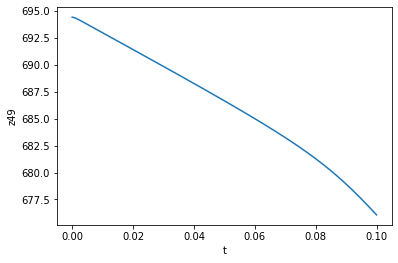

In [170]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

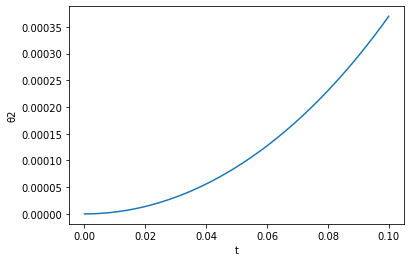

In [171]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

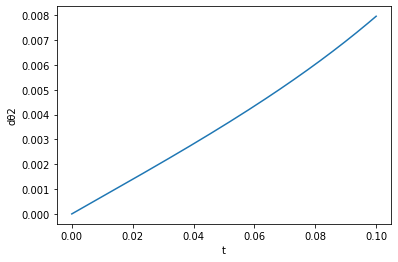

In [172]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

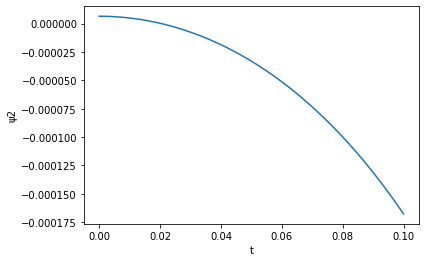

In [173]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

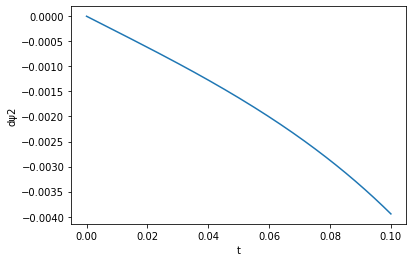

In [174]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()